In [1]:
import numpy as np
import csv
import os
import pandas as pd
import numpy as np
import pickle
import json
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora,models
from gensim.corpora import Dictionary
from sklearn.mixture import DPGMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import guidedlda


In [2]:

kcv_list_of_users_anon_path='KCV_list_of_users_anon.pickle'
user_to_label_anon_path='user_to_label_anon.pickle'
retweet_timelines_anon_path='retweet_timelines_anon.pickle'


In [3]:

with open(kcv_list_of_users_anon_path,'rb') as f:
	KCV_list_of_users_anon=pickle.load(f,encoding='utf-8')
    
with open(user_to_label_anon_path,'rb') as f:
	user_to_label_anon=pickle.load(f,encoding='utf-8')
    
with open(retweet_timelines_anon_path,'rb') as f:
	retweet_timelines=pickle.load(f)


In [4]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()


def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = [lemma.lemmatize(word) for word in punc_free.split()]
    http_free= " ".join(word for word in normalized if not word.startswith(('http','rt')))
    
    return http_free

In [5]:
user_to_docs={}


for user_n_label in retweet_timelines:
    user,label=user_n_label
    retweet_timeline=[tweet['text'] for tweet in retweet_timelines[user_n_label]]
    user_to_docs[user]=set(retweet_timeline)

# squash docs per user together
for user in user_to_docs:
    user_to_docs[user]=' '.join([retweet for retweet in list(user_to_docs[user])])

            



In [6]:

# CREATE TOPIC VECTORS VIA LDA
num_topics=10

def create_LDA(all_docs,num_topics=10):
    
    num_topics=10


    dictionary = corpora.Dictionary(all_docs)
    dictionary.filter_extremes(no_below=5, keep_n=3000)


    bow_corpus = [dictionary.doc2bow(doc) for doc in all_docs]
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=5, workers=10)

    # print topics created.
    for idx, topic in lda_model_tfidf.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return lda_model_tfidf,dictionary
        
all_docs_genuine=[]
all_docs_fake=[]

for user in user_to_docs:
    clean_doc=clean(user_to_docs[user])
    user_to_docs[user]=clean_doc
    
    if user_to_label_anon[user]==1:
        all_docs_genuine.append(clean_doc.split())
    elif user_to_label_anon[user]==0:
        all_docs_fake.append(clean_doc.split())
        
        
    
print("For genuine :")
lda_genuine,dict_genuine=create_LDA(all_docs_genuine,num_topics)
print("For fake :")
lda_fake,dict_fake=create_LDA(all_docs_fake,num_topics)



For genuine :
Topic: 0 Word: 0.005*"wherepond" + 0.004*"vaamilynholdo" + 0.004*"beserioususa" + 0.004*"uber" + 0.004*"rhetoric" + 0.004*"elastigirl2018" + 0.004*"hearing" + 0.003*"certain" + 0.003*"use" + 0.003*"accept"
Topic: 1 Word: 0.007*"liar" + 0.005*"artofthehak" + 0.005*"joehanifnyan" + 0.004*"elon" + 0.004*"tesla" + 0.004*"musk" + 0.004*"spacex" + 0.004*"page" + 0.003*"pie" + 0.003*"time"
Topic: 2 Word: 0.005*"✅" + 0.003*"friendsversary" + 0.003*"celebrated" + 0.003*"become" + 0.003*"though" + 0.003*"tdub909" + 0.003*"nancywonderful" + 0.002*"breach" + 0.002*"decentralized" + 0.002*"elonmusk"
Topic: 3 Word: 0.006*"trx" + 0.006*"beebomco" + 0.005*"tesla" + 0.005*"spacex" + 0.005*"elon" + 0.005*"musk" + 0.004*"page" + 0.004*"deletes" + 0.004*"tron" + 0.004*"movement"
Topic: 4 Word: 0.004*"joindiaspora" + 0.003*"founder" + 0.003*"concern" + 0.003*"bring" + 0.003*"issue" + 0.002*"officialjtw" + 0.002*"purchased" + 0.002*"time" + 0.002*"oligarch" + 0.002*"wher…"
Topic: 5 Word: 0.005

In [7]:
user_to_topic_vectors={}

for key in user_to_docs:
    
    xg=dict_genuine.doc2bow(user_to_docs[key].split())
    xf=dict_fake.doc2bow(user_to_docs[key].split())    

    topic_vector_sparse_genuine=lda_genuine.get_document_topics(xg)
    topic_vector_sparse_fake=lda_fake.get_document_topics(xf)
    
    topic_vector=np.zeros(2*num_topics+2)
    
    for pair in topic_vector_sparse_genuine:
        topic_vector[pair[0]]=pair[1]
        
    for pair in topic_vector_sparse_fake:
        topic_vector[num_topics+pair[0]]=pair[1]
        
    user_to_topic_vectors[key]=topic_vector
#     print(user_to_topic_vectors[key])

# for user in user
def get_timestamp(tweet_creation_time):
	# print tweet_creation_time,"is creation time"
	attbs=tweet_creation_time.split(' ')
	# print attbs
	date_origin=13
	date=int(attbs[2])
	hhmmss=attbs[3].split(':')
	hhmmss=[int(val) for val in hhmmss]
	# print date,hhmmss
	minutes_passed=(date-date_origin)*24*60+(hhmmss[0])*60+hhmmss[1]+hhmmss[2]/60.0
	return minutes_passed

from tick.hawkes import HawkesExpKern

def get_hawkes_params(timestamps):
    decays=0.3
    gofit='likelihood'
    penalty='l2'
    C=1e6
    solver='agd'
    step=None
    tol=1e-05
    max_iter=1000;
    verbose=False
    print_every=10
    random_state=0
    elastic_net_ratio=0.80

#     a_kernel=HawkesExpKern(decays, gofit=gofit, penalty=penalty, C=C, solver=solver, step=step, tol=tol, max_iter=max_iter, verbose=verbose, print_every=print_every, elastic_net_ratio=elastic_net_ratio, random_state=random_state)
    a_kernel=HawkesExpKern(decays, gofit=gofit, penalty=penalty,solver=solver, step=step, tol=tol, max_iter=max_iter, verbose=verbose)
    a_kernel.fit(timestamps)
    
    baseline=a_kernel.baseline[0]
    adj=a_kernel.adjacency[0][0]
#     print(baseline,adj)
    return baseline,adj

baselines=[]
adjs=[]
labels=[]
lbl2int={'fake':0,'genuine':1}

for user_n_label in retweet_timelines:
    user,label=user_n_label
    retweet_timestamp=np.array([get_timestamp(tweet['created_at']) for tweet in retweet_timelines[user_n_label]])
    min_time=np.min(retweet_timestamp)
    max_time=np.max(retweet_timestamp)
    sorted_time=(np.sort(np.unique((retweet_timestamp-min_time)/max_time)))
#     print(sorted_time)
    baseline,adj=get_hawkes_params([sorted_time])
#     break
    baselines.append(baseline)
    labels.append(lbl2int[label])
    adjs.append(adj)
    topic_vector=user_to_topic_vectors[user]
    topic_vector[-1]=baseline
    topic_vector[-2]=adj
    
    user_to_topic_vectors[user]=topic_vector
    
import matplotlib.pyplot as plt
# print(labels)
#plotting adj/mus
plt.scatter(adjs, baselines,s=5,c=labels)
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
X=[]
Y=[]

for user in user_to_label_anon:
    x=user_to_topic_vectors[user]
    y=user_to_label_anon[user]
    X.append(x)
    Y.append(y)
    
X=np.array(X)
# print(X.shape)
Y=np.array(Y)

import pickle
with open('X.pickle','wb') as f:
    pickle.dump(X,f)

with open('Y.pickle','wb') as f:
    pickle.dump(Y,f)

    

(2508, 2)
(507, 2)


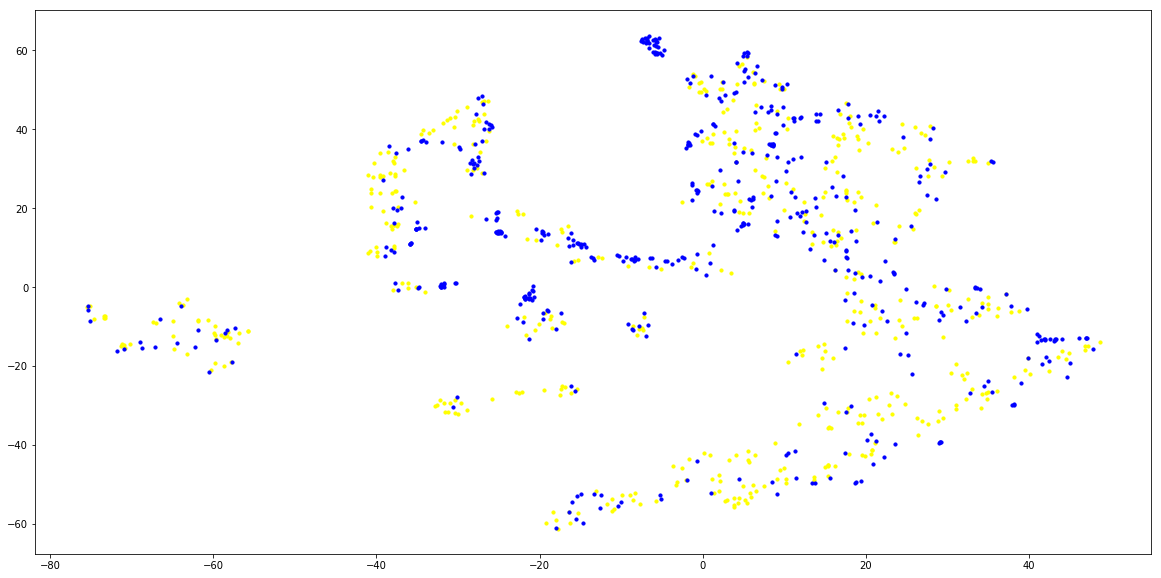

In [9]:
#Visualize the text topical vectors using tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


tsne_model = TSNE(n_components=2)
X_embedded=tsne_model.fit_transform(X)
print(X_embedded.shape)
# pca = PCA(n_components=2)
# X_embedded = pca.fit_transform(X)

X_f=X_embedded[np.where(Y==0)]
X_g=X_embedded[np.where(Y==1)]

print(X_f.shape)
plt.figure(figsize=(20,10))
plt.scatter(X_g[:500, 0], X_g[:500, 1], c='yellow', s=10, cmap='viridis')
plt.scatter(X_f[:, 0], X_f[:, 1], c='blue', s=10, cmap='viridis')

# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, s=14, cmap='viridis')
plt.show()

In [10]:
from sklearn.mixture import DPGMM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# print(KCV_list_of_users)
ap=ar=af1=aacc=0



#balanced K fold
for fold in KCV_list_of_users_anon:
    
#     print((fold[0]))
    fold=list(set(fold[0])),list(set(fold[1]))
#     print(len(fold[0]),len(fold[1]))

    X_train=np.array([user_to_topic_vectors[user] for user in fold[0]])
#     print(type(fold[1]))
    X_test=np.array([user_to_topic_vectors[user] for user in fold[1]])
    Y_train=np.array([user_to_label_anon[user] for user in fold[0]])
    Y_test=np.array([user_to_label_anon[user] for user in fold[1]])
    
#     print
#     print(np.unique(Y_test,return_counts=True))
#     X_train_embedded=tsne_model.fit_transform(X_train)
    
#     plt.scatter(X_train_embedded[:, 0], X_train_embedded[:, 1], c=Y_train, s=10, cmap='viridis')    
#     plt.show()

    neigh = KNeighborsClassifier(n_neighbors=1)
#     print(fold[1])
#     neigh = GaussianNB()

#     neigh=SVC()
#     print(X_train.shape)
#     neigh=LogisticRegression()
    neigh.fit(X_train[:,:], Y_train)
    labels = neigh.predict(X_test[:,:])
#     print(labels)
    
#     ctr=0
    lens=[]
    for i,label in enumerate(labels):
        if label==0 and Y_test[i]==1:
            #false negative
            try:
#                 print(len(retweet_timelines[(fold[1][i],'genuine')]))
                lens.append(len(retweet_timelines[(fold[1][i],'genuine')]))
#                 break
            except Exception as e:
#                 print("hh")
                pass
#             ctr+=1
#     print(np.sort(np.array(lens)))
#     print(len(lens))
#     exit
#     print(ctr)
#             print(retweet_timelines[fold[1][i]])
            
#     print (classification_report(Y_test,labels))
    a=accuracy_score(Y_test,labels)
    p,r,f1,_=precision_recall_fscore_support(Y_test,labels,average='macro')
    # print(p,r,f1)
    aacc+=a/len(KCV_list_of_users_anon)
    ap+=p/len(KCV_list_of_users_anon)
    ar+=r/len(KCV_list_of_users_anon)
    af1+=f1/len(KCV_list_of_users_anon)
print("avg prec:",round(ap,3),"avg rec:",round(ar,3),"avg f1:",round(af1,3),"avg acc:",round(aacc,3))


avg prec: 0.964 avg rec: 0.911 avg f1: 0.928 avg acc: 0.961


In [11]:
#imbalanced K fold
# print(X.shape)
# print(Y.shape)

# import numpy as np
X=X[:,-2:]
# Y=Y
from sklearn.model_selection import KFold
n_splits=5
kf = KFold(n_splits)
kf.get_n_splits(X)

# print(kf)  
afp=agp=0
afr=agr=0
aff1=agf1=0

for train_index, test_index in kf.split(X):
    #    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    neigh = KNeighborsClassifier(n_neighbors=1)
    #     print(fold[1])
#     neigh = GaussianNB()
#     neigh=SVC()
    #     print(X_train.shape)
#     neigh=LogisticRegression()
    neigh.fit(X_train, Y_train)
    labels = neigh.predict(X_test)
    
#     print(classification_report(Y_test,labels))
    c_str=classification_report(Y_test,labels)
    f_str=c_str.split('\n')[2].split()
    g_str=c_str.split('\n')[3].split()

    fp=float(f_str[1])
    fr=float(f_str[2])
    ff1=float(f_str[3])


    gp=float(g_str[1])
    gr=float(g_str[2])
    gf1=float(g_str[3])
    
    afp+=fp/n_splits
    afr+=fr/n_splits
    aff1+=ff1/n_splits
    
    agp+=gp/n_splits
    agr+=gr/n_splits
    agf1+=gf1/n_splits

print(round(afp,3)," & ",round(afr,3)," & ",round(aff1,3)," & & ",round(agp,3)," & ",round(agr,3)," & ",round(agf1,3))
# print(agp,agr,agf1)
   



0.28  &  0.302  &  0.288  & &  0.818  &  0.8  &  0.808


In [12]:
c_str=classification_report(Y_test,labels)
    
f_str=c_str.split('\n')[2].split()
g_str=c_str.split('\n')[3].split()

fp=float(f_str[1])
fr=float(f_str[2])
ff1=float(f_str[3])


gp=float(g_str[1])
gr=float(g_str[2])
gf1=float(g_str[3])

print(fp,fr,ff1)

    


0.34 0.35 0.34
